In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "7"  # Set the GPU 2 to use

In [52]:
from faster_whisper import WhisperModel

model = WhisperModel("imTak/faster-whisper_Korean_L3turbo", device="cpu")

# segments, info = model.transcribe("audio.mp3")
# segments, info = model.transcribe("audio2.wav")
for fil in ["test.wav", 'test.wav']:
    segments, info = model.transcribe(fil, language='ko')
    for segment in segments:
        print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))


INFO:faster_whisper:Processing audio with duration 00:17.911


[0.00s -> 17.91s] 제 인생은 왜 이래요 왜 나만 이렇게 죽 같아요 벗어나고 싶어서 이제 진짜 저쪽으로 가야겠다


INFO:faster_whisper:Processing audio with duration 00:17.911


[0.00s -> 17.91s] 제 인생은 왜 이래요 왜 나만 이렇게 죽 같아요 벗어나고 싶어서 이제 진짜 저쪽으로 가야겠다


In [ ]:
from simple_diarizer.diarizer import Diarizer
from simple_diarizer.utils import (check_wav_16khz_mono, convert_wavfile,
                                   waveplot, combined_waveplot, waveplot_perspeaker)

import os
import tempfile
from pprint import pprint

import matplotlib.pyplot as plt
import soundfile as sf

from IPython.display import Audio, display, HTML
from tqdm.autonotebook import tqdm


Using cache found in /home/gue707/.cache/torch/hub/snakers4_silero-vad_master
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_

Converting audio file to single channel WAV using ffmpeg...


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 11.2.0 (Anaconda gcc)
  configuration: --prefix=/croot/ffmpeg_1722024521393/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_ --cc=/croot/ffmpeg_1722024521393/_build_env/bin/x86_64-conda-linux-gnu-cc --ar=/croot/ffmpeg_1722024521393/_build_env/bin/x86_64-conda-linux-gnu-ar --nm=/croot/ffmpeg_1722024521393/_build_env/bin/x86_64-conda-linux-gnu-nm --ranlib=/croot/ffmpeg_1722024521393/_build_env/bin/x86_64-conda-linux-gnu-ranlib --strip=/croot/ffmpeg_1722024521393/_build_env/bin/x86_64-conda-linux-gnu-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfont

Running VAD...
Splitting by silence found 288 utterances
Extracting embeddings...


Utterances: 100%|██████████| 288/288 [00:01<00:00, 156.41it/s]
/home/gue707/.conda/envs/test/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


Clustering to 3 speakers...
Cleaning up output...
Done!


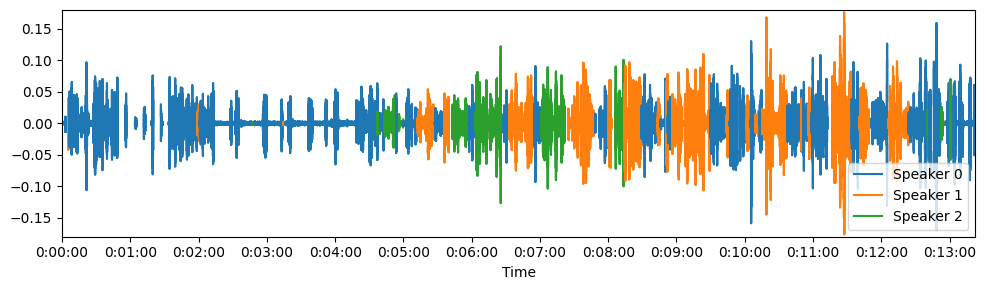

In [14]:
import soundfile as sf
import matplotlib.pyplot as plt

from simple_diarizer.diarizer import Diarizer
from simple_diarizer.utils import combined_waveplot

diar = Diarizer(
                  embed_model='xvec', # 'xvec' and 'ecapa' supported
                  cluster_method='sc' # 'ahc' and 'sc' supported
               )
WAV_FILE = '/home/gue707/PromptStyler/test/y2mate.com-이마고-대화영상.wav'
segments = diar.diarize(WAV_FILE, num_speakers=3)

signal, fs = sf.read(WAV_FILE)
combined_waveplot(signal, fs, segments)
plt.show()

In [21]:
import numpy as np

people = [[], [], []]

for seg in segments:
    start = seg["start_sample"]
    end = seg["end_sample"]
    speech = signal[start:end]
    people[seg["label"]].append(speech)

        # save the speech to a "result/{label}_{start}_{end}.wav" file
for i, person in enumerate(people):
    sf.write(f"result/{i}.wav", np.concatenate(person), fs)

In [2]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "imTak/whisper_large_v3_ko_ft_ft"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)


/home/gue707/.conda/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
result = pipe(['test.wav', 'test.wav'])
print(result)

/home/gue707/.conda/envs/test/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/home/gue707/.conda/envs/test/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[{'text': '제 인생은 왜 이래요 왜 나만 이렇게 죽 같아요 벗어나고 싶어서 이제 진짜 저게 다 됐다'}, {'text': '제 인생은 왜 이래요 왜 나만 이렇게 죽 같아요 벗어나고 싶어서 이제 진짜 저게 다 됐다'}]
